In [1]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [3]:
# !pip install pycocotools
from pycocotools.coco import COCO

In [4]:
from albumentations.pytorch import ToTensorV2

In [13]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [22]:
class Data(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):

        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed['image']
        boxes = transformed['bboxes']

        new_boxes = []
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [12]:
!curl -L "https://public.roboflow.com/ds/9MYy0P1ctc?key=bva5WQfEFB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   3363      0 --:--:-- --:--:-- --:--:--  3357
100 78.6M  100 78.6M    0     0  58.3M      0  0:00:01  0:00:01 --:--:-- 68.1M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.dataset.txt      
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: README.roboflow.txt     
 extracting: test/0b47311f426ff926578c9d738d683e76_jpg.rf.0b55f43ac16aa65c889558d8ea757072.jpg  
 extracting: test/1c0060ef868bdc326ce5e6389cb6732f_jpg.rf.9ce88078ea356949f4ab7ad9cfdfc62d.jpg  
 extracting: test/2f6fb003bb89cd401322a535acb42f65_jpg.rf.91ad9df05bd1f86bab67c8368ae5e4ad.jpg  
 extracting: test/410993714e325a1de3e394ffe860df3a_jpg.rf.519bf0fdbd5e38cd44cae1cfebc98536.jpg  
 extracting: test/4e3117459d759798537eb52cf5bf534d_jpg.rf.5b

In [19]:
dataset_path = "/content/"

In [10]:
import os

In [23]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'pieces', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'bishop', 'supercategory': 'pieces'},
 2: {'id': 2, 'name': 'black-bishop', 'supercategory': 'pieces'},
 3: {'id': 3, 'name': 'black-king', 'supercategory': 'pieces'},
 4: {'id': 4, 'name': 'black-knight', 'supercategory': 'pieces'},
 5: {'id': 5, 'name': 'black-pawn', 'supercategory': 'pieces'},
 6: {'id': 6, 'name': 'black-queen', 'supercategory': 'pieces'},
 7: {'id': 7, 'name': 'black-rook', 'supercategory': 'pieces'},
 8: {'id': 8, 'name': 'white-bishop', 'supercategory': 'pieces'},
 9: {'id': 9, 'name': 'white-king', 'supercategory': 'pieces'},
 10: {'id': 10, 'name': 'white-knight', 'supercategory': 'pieces'},
 11: {'id': 11, 'name': 'white-pawn', 'supercategory': 'pieces'},
 12: {'id': 12, 'name': 'white-queen', 'supercategory': 'pieces'},
 13: {'id': 13, 'name': 'white-rook', 'supercategory': 'pieces'}}

In [24]:
classes = [i[1]['name'] for i in categories.items()]
classes

['pieces',
 'bishop',
 'black-bishop',
 'black-king',
 'black-knight',
 'black-pawn',
 'black-queen',
 'black-rook',
 'white-bishop',
 'white-king',
 'white-knight',
 'white-pawn',
 'white-queen',
 'white-rook']

In [25]:
train_dataset = Data(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


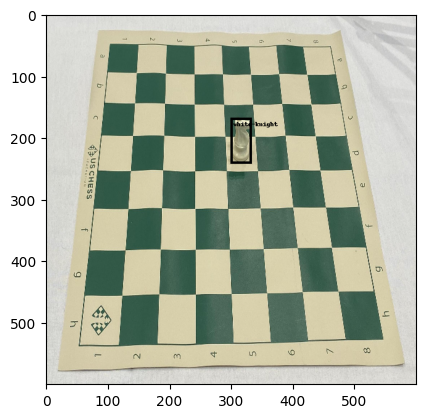

In [26]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [27]:
len(train_dataset)

202

In [28]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 150MB/s]


In [29]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [30]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [31]:
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [32]:
device = torch.device("cuda")

In [33]:
model = model.to(device)

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [35]:
import pandas as pd
import numpy as np
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()


    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig") # train if loss becomes infinity
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()


    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

In [36]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 51/51 [00:13<00:00,  3.67it/s]


Epoch 0, lr: 0.010000, loss: 1.512025, loss_classifier: 0.832441, loss_box: 0.645084, loss_rpn_box: 0.019429, loss_object: 0.015070


100%|██████████| 51/51 [00:12<00:00,  4.23it/s]


Epoch 1, lr: 0.010000, loss: 1.094058, loss_classifier: 0.560418, loss_box: 0.516201, loss_rpn_box: 0.009315, loss_object: 0.008124


100%|██████████| 51/51 [00:13<00:00,  3.75it/s]


Epoch 2, lr: 0.010000, loss: 0.981805, loss_classifier: 0.465525, loss_box: 0.500103, loss_rpn_box: 0.009441, loss_object: 0.006736


100%|██████████| 51/51 [00:15<00:00,  3.27it/s]


Epoch 3, lr: 0.010000, loss: 0.946044, loss_classifier: 0.433214, loss_box: 0.499747, loss_rpn_box: 0.008182, loss_object: 0.004902


100%|██████████| 51/51 [00:12<00:00,  4.09it/s]


Epoch 4, lr: 0.010000, loss: 0.822093, loss_classifier: 0.344692, loss_box: 0.464437, loss_rpn_box: 0.007309, loss_object: 0.005655


100%|██████████| 51/51 [00:11<00:00,  4.26it/s]


Epoch 5, lr: 0.010000, loss: 0.815832, loss_classifier: 0.319520, loss_box: 0.485243, loss_rpn_box: 0.006670, loss_object: 0.004398


100%|██████████| 51/51 [00:14<00:00,  3.63it/s]


Epoch 6, lr: 0.010000, loss: 0.724790, loss_classifier: 0.285917, loss_box: 0.426568, loss_rpn_box: 0.007362, loss_object: 0.004943


100%|██████████| 51/51 [00:14<00:00,  3.47it/s]


Epoch 7, lr: 0.010000, loss: 0.794562, loss_classifier: 0.303177, loss_box: 0.480941, loss_rpn_box: 0.006605, loss_object: 0.003839


100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


Epoch 8, lr: 0.010000, loss: 0.805554, loss_classifier: 0.296489, loss_box: 0.499034, loss_rpn_box: 0.005893, loss_object: 0.004137


100%|██████████| 51/51 [00:12<00:00,  4.10it/s]

Epoch 9, lr: 0.010000, loss: 0.768563, loss_classifier: 0.279531, loss_box: 0.479175, loss_rpn_box: 0.005771, loss_object: 0.004086


In [37]:
model.eval()
torch.cuda.empty_cache()

In [38]:
test_dataset = Data(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [39]:
img, _ = test_dataset[5]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

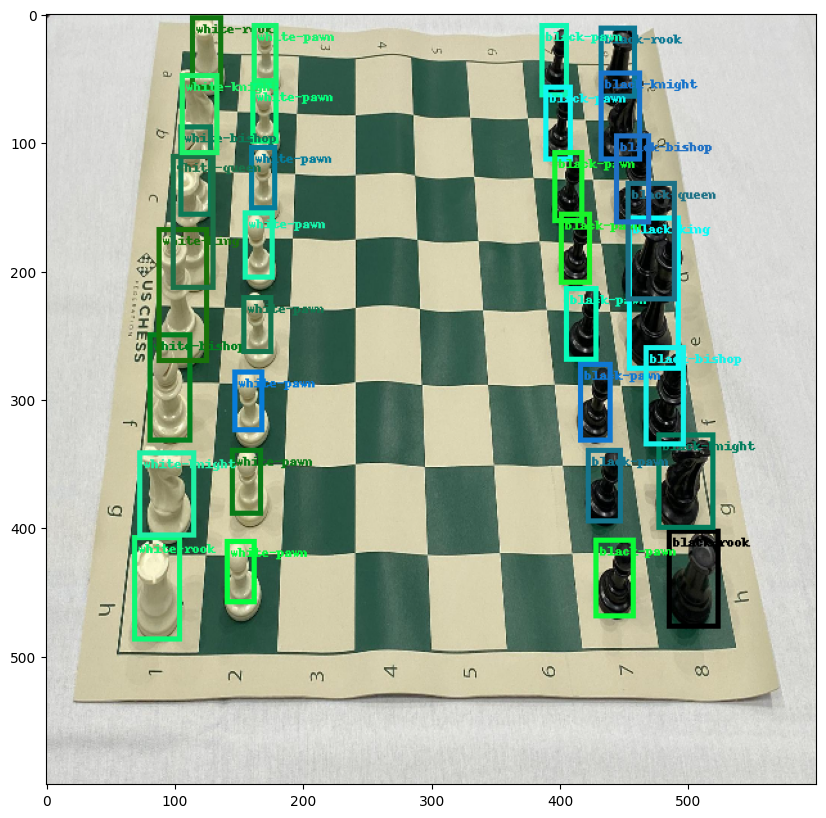

In [40]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))